In [1]:
from ml_bay12.GCS import GCSLoader
from ml_bay12 import data_prepare
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
gcs=GCSLoader(project='open-mafia-ml-bay12',path='om-ml-bay12-storage/dataset/ds_mafia')
post_train=gcs.get_post()
role_train=gcs.get_role()
post_test=gcs.get_post(which='test')
role_test=gcs.get_role(which='test')

In [4]:
post_train["text"]=post_train["text"].apply(data_prepare.clean)
post_test["text"]=post_test["text"].apply(data_prepare.clean)

In [5]:
users_df=data_prepare.concat_users_text(post_train)
users_test_df=data_prepare.concat_users_text(post_test)


In [6]:
main_df = data_prepare.get_users_in_game(role_train, users_df)
main_test_df = data_prepare.get_users_in_game(role_test, users_test_df)

In [7]:
train_data=main_df["text"]
y=main_df["role_id"]
y_test=gcs.get_role_answers()["role_id"]
test_data=main_test_df["text"]


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
X_vect_train =vectorizer.fit_transform(train_data).toarray()
X_vect_test =vectorizer.transform(test_data).toarray()
X_vect_train.shape

(478, 7946)

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=300)
X_train = pca.fit_transform(X_vect_train)
X_test = pca.fit_transform(X_vect_test)

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
clf = LogisticRegression(random_state=0, class_weight='balanced', C=0.1, solver='lbfgs')

In [31]:
clf.fit(X_train,y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [32]:
pred_y = clf.predict(X_test)
probs_y = clf.predict_proba(X_test)

In [33]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc

In [34]:
roc_auc_score(y_test, probs_y[:,1])

0.5168113339319564

(0, 1)

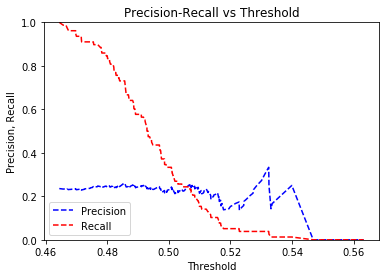

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])